## Data Science Workflow

In standard software development code not working can be caused by a number of factors along two dimensions

* Bugs in implementation
* Algorithm design

For machine learning problems,, have many more dimensions:
* Bugs in implementation
* Algorithm design
* Model issues
* Data quality

In [63]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [64]:
train = pd.read_csv('train.csv')

holdout = pd.read_csv('test.csv')

holdout.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [65]:
# %load functions.py
def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [66]:
def apply_function(df):
    df = process_missing(df)
    df = process_age(df)
    df = process_fare(df)
    df = process_titles(df)
    df = process_cabin(df)
    df = create_dummies(df, "Age_categories")
    df = create_dummies(df, "Fare_categories")
    df = create_dummies(df, "Cabin_type")
    df = create_dummies(df, "Sex")
    
    return df

In [67]:
# Apply the function

train = apply_function(train)

holdout = apply_function(holdout)

### Kaggle Workflow

* **Data exploration**, to find patterns in the data
* **Feature engineering**, to create new features from those patterns or through pure experimentation
* **Feature selection**, to select the best subset of our current set of features
* **Model selection/tuning**, training a number of models with different hyperparameters to find the best performer.

In [68]:
train['SibSp'].describe()

count    891.000000
mean       0.523008
std        1.102743
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        8.000000
Name: SibSp, dtype: float64

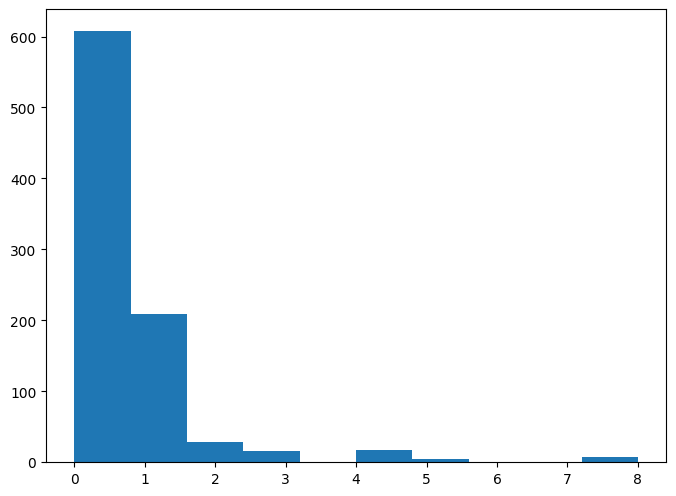

In [69]:
plt.figure(figsize=(8,6))
plt.hist(train['SibSp'])
plt.show()

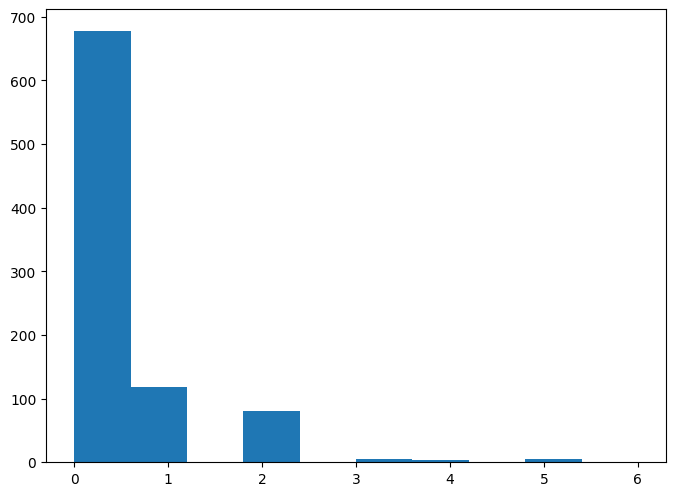

In [70]:
plt.figure(figsize=(8,6))
plt.hist(train['Parch'])
plt.show()

In [71]:
train['Parch'].describe()

count    891.000000
mean       0.381594
std        0.806057
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        6.000000
Name: Parch, dtype: float64

In [72]:
train['SibSp'].value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

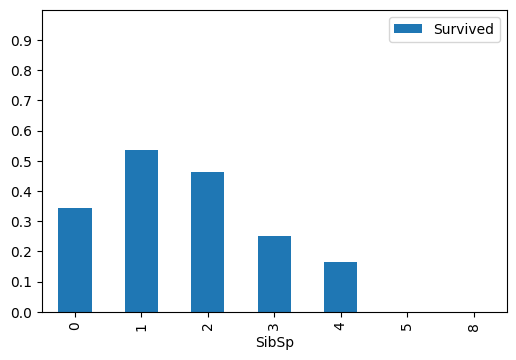

In [73]:
explore_cols = ["SibSp","Parch","Survived"]
explore = train[explore_cols].copy()

explore['familysize'] = explore[["SibSp","Parch"]].sum(axis=1)
pivot = explore.pivot_table(index='SibSp',values="Survived")
pivot.plot.bar(ylim=(0,1),yticks=np.arange(0,1,.1))
plt.show()

In [74]:
def family_member(df):
    isalone = (df['SibSp'] + df['Parch']) == 0
    df['isalone'] = isalone
    df['isalone'] = df['isalone'].apply(lambda x:1 if x == True else 0)
    return df

In [75]:
train = family_member(train)
holdout = family_member(holdout)

In [76]:
train['isalone'].value_counts()

1    537
0    354
Name: isalone, dtype: int64

In [77]:
holdout['isalone'].value_counts()

1    253
0    165
Name: isalone, dtype: int64

In [78]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

In [79]:
testing = train.copy()

In [80]:
def select_features(df):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

    # Only include numerical datatype columns
    newdf = testing.select_dtypes(include=numerics)

    # Define Dataframes   
    all_X = newdf.drop(['PassengerId','Survived'], axis=1)
    all_y = newdf['Survived']

    # Instantiate Classifier
    rf = RandomForestClassifier(random_state=1)
    
    # Apply recursive feature elimination
    selector = RFECV(rf, cv = 10)
    selector = selector.fit(all_X, all_y)
    optimized_columns = all_X.columns[selector.support_]
    
    print(optimized_columns)
    
    return optimized_columns

In [81]:
# Keep and print the best columns for training
best_columns = select_features(train)


Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'isalone'], dtype='object')


In [82]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

In [83]:
def select_model(df, feature_list):
    feature_list = best_columns
    all_X = df[feature_list]
    all_y = df['Survived']

    dict1 = {"name":"KNeighborsClassifier",
         "estimator":KNeighborsClassifier(),
         "hyperparameters":
             {
            "n_neighbors": range(1,20,2),
            "weights": ["distance", "uniform"],
            "algorithm": ["ball_tree", "kd_tree", "brute"],
            "p": [1,2]
             }
        }

    dict2 = {"name":"LogisticRegression",
         "estimator":LogisticRegression(),
         "hyperparameters":
                  {"solver":["newton-cg", "lbfgs", "liblinear"]
                  }
        }

    dict3 = {"name":"RandomForestClassifier",
        "estimator":RandomForestClassifier(),
        "hyperparameters": 
              {"n_estimators": [4, 6, 9],
               "criterion": ["entropy", "gini"],
               "max_depth": [2, 5, 10],
               "max_features": ["log2", "sqrt"],
               "min_samples_leaf": [1, 5, 8],
               "min_samples_split": [2, 3, 5]   
              }
        }

    all_models = [dict1,dict2,dict3]

    for model in all_models:
        print(model["name"])
        grid = GridSearchCV(model["estimator"], param_grid = model["hyperparameters"], cv = 10)
        grid.fit(all_X,all_y)
    
    
        model["best_params"] = grid.best_params_
        model["best_score"] = grid.best_score_
    
        print(model["best_params"])
        
        print(model["best_score"])
        
    return all_models

In [84]:
training_outputs = select_model(train, best_columns)

KNeighborsClassifier
{'algorithm': 'brute', 'n_neighbors': 17, 'p': 1, 'weights': 'distance'}
0.6981897627965045
LogisticRegression
{'solver': 'newton-cg'}
0.7206242197253434
RandomForestClassifier
{'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 9}
0.7397003745318352


In [85]:
## Submission

In [86]:
training_outputs[0]

{'name': 'KNeighborsClassifier',
 'estimator': KNeighborsClassifier(),
 'hyperparameters': {'n_neighbors': range(1, 20, 2),
  'weights': ['distance', 'uniform'],
  'algorithm': ['ball_tree', 'kd_tree', 'brute'],
  'p': [1, 2]},
 'best_params': {'algorithm': 'brute',
  'n_neighbors': 17,
  'p': 1,
  'weights': 'distance'},
 'best_score': 0.6981897627965045}

In [87]:
def save_submission_file(model, features, *filename):
    prediction = model.predict(holdout[features])
    submission = pd.DataFrame({
        'PassengerId': holdout['PassengerId'],
        'Survived': prediction
    })
    submission.to_csv(filename, index=False)
    return submission

In [88]:
#save_submission_file(training_outputs[0], best_columns, 'submission.csv')

AttributeError: 'dict' object has no attribute 'predict'